# Plotting

Notebook dedicated to plotting the results of the explainer calculations. Results are generated using the Array_Submission.py file which is designed to work with array_submission.py as a generator of slurm files for use on the Merlin cluster. The notebook relies on being in the same folder as an Array_Submission folder containing the results and the files:

    BaseDuffing.py
    RandomDuffing.py
    EnergyDuffing.py
    GammaDuffing.py

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import solve_ivp

import xgboost as xgb

import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

%matplotlib inline


import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
tf.random.set_seed(42)
np.random.seed(42)




## Choosing the Configuration to Plot

Here we choose which configuration to generate plots for:
    Settings allows us to choose the additional variable to be used in training and explaining the neural networks.
    Model_types concerns which network or simulation we are explaining.
    Param_array contains the parameter configurations of the Duffing Oscillator for which we have data. 
    
Choosing a configuration selects the dataset containing the explainability results and also the data generation process for the training data used in training the NNs.

In [2]:
Settings=["Base", "Random", "Energy","Gamma"]
Model_types=["True", "Complex", "Simple"]
Param_array = [{'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 1.0, 'omega' : 1.2},
                  {'alpha' : 1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2}, 
                  {'alpha' : -1.0, 'beta' : -1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 1.2},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.37, 'delta' : 0.3, 'omega' : 0.1},
                  {'alpha' : -1.0, 'beta' : 1.0, 'gamma' : 0.5, 'delta' : 0.3, 'omega' : 1.2}]

i = 1
k = 1

feature_setting = Settings[i]
params = Param_array[k]

plot_features = [r"$x_0$", r"$v_0$", r"$t$"] # latex mathmode feature and label names for better plots
plot_labels = [r"$x_t$", r"$v_t$"]

model_names = {"True" : "Simulation", "Complex" : "DNN", "Simple" : "SNN"} # better model names for plotting

if feature_setting == "Gamma":
    plot_features.append(r"$\gamma$")
else:
    plot_features.append(feature_setting)


# choose the results folder to look at  
results_folder = "Array_Submission/"

if feature_setting == "Base":
    from Array_Submission.BaseDuffing import Duffing
elif feature_setting == "Random":
    from Array_Submission.RandomDuffing import Duffing
elif feature_setting == "Energy":
    from Array_Submission.EnergyDuffing import Duffing
elif feature_setting == "Gamma":
    from Array_Submission.GammaDuffing import Duffing

# decide on whether and how to save the data
save = False
save_suffix = "_setting_"+str(i)+"_param_"+str(k)

In [3]:
# create the instance of the duffing oscillator and generate some data

duffing = Duffing(parameters = params)
features = duffing.features
labels = duffing.labels
end_time = 100
duffing.generate(200, samples = 50, end_time = end_time)


"""
    train the scaler as it is required to translate the data. 
    this scaler should be close enough to the one originally used in generating the data to not make a difference
"""
duffing.scale_features() 

Generating Data…: 100%|██████████████████| 200/200 [00:05<00:00, 34.31it/s]


In [4]:
# load the dataset and trained models

big_df = pd.DataFrame()
models = {}
histories = {}
for j in Model_types:
    print("Loading Model: "+ j)
    suffix = feature_setting + "_" + j + "_" + duffing.suffix
    temp_df = pd.read_csv(results_folder+"Results/explainer_dataframe_"+suffix+".csv")
    temp_df.insert(0, "Model", [j for i in range(temp_df.shape[0])])
    big_df = big_df.append(temp_df)
    if j == "True":
        models[j] = duffing
        histories[j] = None
    elif j != "True":
        models[j] = tf.keras.models.load_model(results_folder+"Models/Model"+suffix)
        histories[j] = pickle.load(open(results_folder+'Models/TrainingHistory/'+suffix, "rb"))  
        
X = pd.DataFrame(duffing.scaler.inverse_transform(big_df[features]), columns = features)
y = pd.DataFrame(duffing.predict(big_df[features]), columns = labels)

Loading Model: True
Loading Model: Complex
Loading Model: Simple


In [5]:
# choose random subset of the generated data
choice = duffing.X_df[features].iloc[np.sort(np.random.choice(duffing.X_df[features].shape[0], 500, replace =False))]
# get the true values associated with the initial values from the generated data
model_plot = {"True" : pd.DataFrame(duffing.predict(choice), columns = duffing.labels)}
# get the t values that correspond to the predictions made above
plot_t = pd.DataFrame(duffing.scaler.inverse_transform(choice), columns = features)['t']


# get the true values associated with the initial values from the imported data
y_pred = {"True" : pd.DataFrame(duffing.predict(big_df[features]), columns = duffing.labels)}

## Model Performance Plot

Here we plot the model performance for the SNN and DNN. In the loss plot the MSE is plotted. The error plot compares the predictions for the best 95% of predictions with the simulated values.

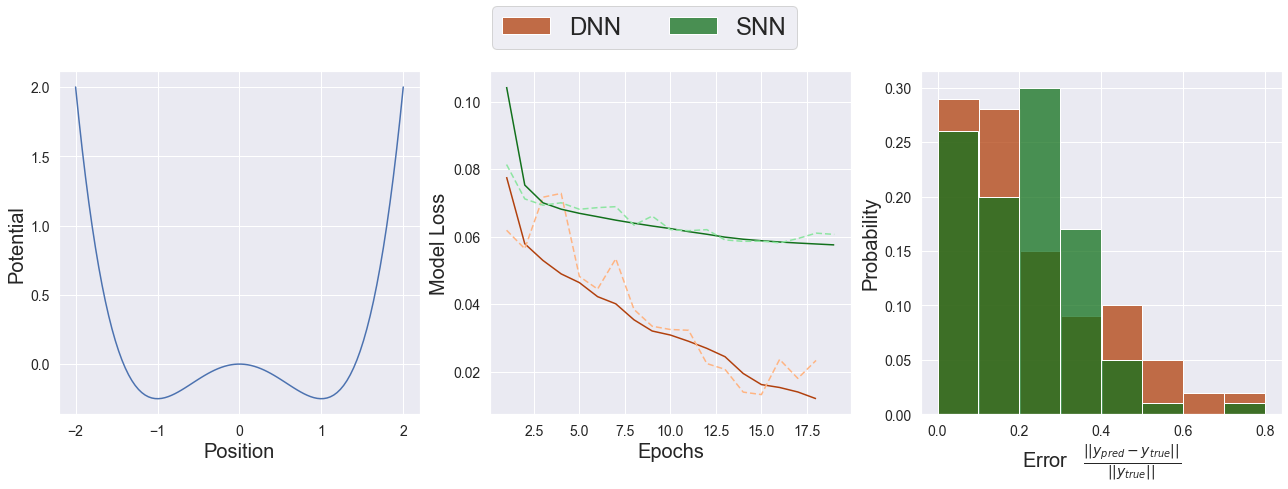

In [6]:
# define colour palettes for the plots
colours = {"Complex" : sns.color_palette("dark")[1], "Simple" : sns.color_palette("dark")[2]}
colours_line = {"Complex" : [sns.color_palette("dark")[1], sns.color_palette("pastel")[1]], 
                "Simple" : [sns.color_palette("dark")[2], sns.color_palette("pastel")[2]]}


f, axs = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw=dict(width_ratios=[4,4,4]))

# plot the underlying potential of the system
x_potential = np.linspace(-2,2,100)
v_potential = 0
y_potential = (0.5*v_potential**2 + 0.5*params['alpha']*x_potential**2 +0.25*params['beta']*x_potential**4)
sns.lineplot(x = x_potential, y=y_potential,ax=axs[0])
axs[0].set_xlabel('Position', fontsize = 20)
axs[0].set_ylabel('Potential', fontsize = 20)

# for the DNN and SNN calculate the error and Plot the MSE loss and error plots
for model_ in ["Complex", "Simple"]:
    model = models[model_]
    history = histories[model_]
    
    # Make Prdictions on the Test Dataset
    y_pred[model_] = pd.DataFrame(model.predict(big_df[features]), columns = duffing.labels)
    model_plot[model_] = pd.DataFrame(model.predict(choice), columns = duffing.labels)


    # evaluate the fitting validation and training losses
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    pred_norm = np.linalg.norm(y_pred[model_][['xt','vt']].values,axis=1)
    true_norm = np.linalg.norm(y_pred["True"][['xt','vt']].values,axis=1)
    hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
    hist_data = pd.DataFrame(hist_data, columns=['norm'])

    def Remove_Outlier_Indices(df):
        Q1 = df.quantile(0.00)
        Q3 = df.quantile(0.95)
        IQR = Q3 - Q1
        trueList = ~((df > (Q3 + 1.5 * IQR)))
        #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
        return trueList

    indices = Remove_Outlier_Indices(hist_data)
    hist_data = hist_data[indices]
    
    # Model Loss plot for DNN and SNN
    df1 = pd.DataFrame({"Epochs" : epochs, 
                        "Type" : [str("Training") for i in range(len(history["loss"]))], 
                        "Loss" : history["loss"]})
    df2 = pd.DataFrame({"Epochs" : epochs, 
                        "Type" : [str("Validation") for i in range(len(history["loss"]))], 
                        "Loss" : history["val_loss"]})
    
    hist_arr = pd.concat([df1,df2], ignore_index=True)
    sns.lineplot(data = hist_arr, x = 'Epochs', y='Loss',ax=axs[1], hue = "Type", style = "Type", 
                 dashes = [(4,0),(4,2)], palette = colours_line[model_], legend = False)
    axs[1].set_xlabel('Epochs', fontsize = 20)
    axs[1].set_ylabel('Model Loss', fontsize = 20)

    # Error Plot for DNN and SNN
    sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.1, ax=axs[2], label = model_names[model_], color = colours[model_])
    axs[2].set_xlabel(r'Error   $\frac{||y_{pred}-y_{true}||}{||y_{true}||}$', fontsize = 20)
    axs[2].set_ylabel('Probability', fontsize = 20)

f.legend( bbox_to_anchor=(0, 1, 1, 0), loc="lower center",  ncol=2, fontsize = 24, columnspacing=2)

axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)
f.tight_layout()

if save == True:
    f.savefig("Images/Performance/Perf"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")


## Prediction Plot

Here we plot the model predictions for the simulation, DNN and SNN. Plotted are the slices: x-v, x-t, v-t.

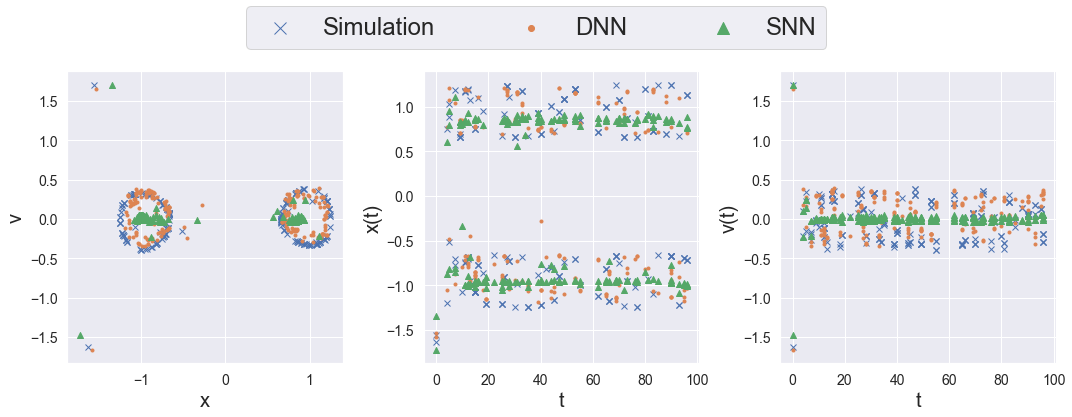

In [7]:
# Predictions Plot ML Model
f, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw=dict(width_ratios=[4,4,4]))
markers = {"True" : 'x', "Complex" : '.', "Simple" : '^'}

for model_ in Model_types:
    # phase space plot
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = 'xt', y='vt',ax=axs[0], label=model_names[model_],
                marker=markers[model_], linewidth = 1, edgecolor = None)
    # xt against time
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = plot_t[:200], y='xt',ax=axs[1],
                marker=markers[model_], linewidth = 1, edgecolor = None, legend = False)
    # vt against time
    sns.scatterplot(data = model_plot[model_].iloc[:200,:], x = plot_t, y='vt',ax=axs[2],
                marker=markers[model_], linewidth = 1, edgecolor = None, legend = False)


axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)
#axs[0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[0].set_xlabel('x', fontsize = 20)
axs[0].set_ylabel('v', fontsize = 20)
#axs[0].set_title("Phase Space Plot", fontsize = 14)
axs[0].legend(loc = 4)

#axs[1].set(xlim=(-1, 100), ylim=(-2, 2))
axs[1].set_xlabel('t', fontsize = 20)
axs[1].set_ylabel('x(t)', fontsize = 20)
#axs[1].set_title("x(t)", fontsize = 14)
#axs[1].legend(loc = 4)

#axs[2].set(xlim=(-1, 100), ylim=(-2, 2))
axs[2].set_xlabel('t', fontsize = 20)
axs[2].set_ylabel('v(t)', fontsize = 20)
#axs[2].set_title("v(t)", fontsize = 14)
#axs[2].legend(loc = 4)

f.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center",  ncol=3, fontsize = 24, columnspacing=3, markerscale = 2)
axs[0].get_legend().remove()
#f.suptitle("Model Predictions", fontsize = 16)
f.tight_layout()

if save == True:
    f.savefig("Images/Predictions/Preds"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

In [8]:
def find_bad(data, y_pred = y_pred, model="Complex", number = 10):
    """
        Function to find the worst predictions in the dataset.
        Args:
            data : explainability dataframe loaded in (big_df)
            y_pred : predictions made on data
            model : ml model for which to evaluate the predictions (in ["True", "Complex", "Simple"])
            number : number of worst predictions to return
        returns: dataframe of "number" worst predictions
    """
    out_df = pd.DataFrame()
    for explainer in big_df["explainer"].unique()[:3]:
        y_exp = y_pred[model].loc[np.where((big_df["explainer"]==explainer)*(big_df["Model"] == model))].reset_index()
        y_true = y_pred["True"].loc[np.where((big_df["explainer"]==explainer)*(big_df["Model"] == "True"))].reset_index()
    
        data_ = data.where(big_df["Model"]==model).where(big_df["explainer"]==explainer).dropna().reset_index().loc[np.argsort(np.linalg.norm(y_true-y_exp, axis = 1))[:number]]
        data_[duffing.features] = duffing.scaler.inverse_transform(data_[duffing.features])
        out_df = out_df.append(data_)
    
    return out_df.reset_index()


## Explainability Plots

Individual feature attributions for SHAP, Shapley values and LIME.

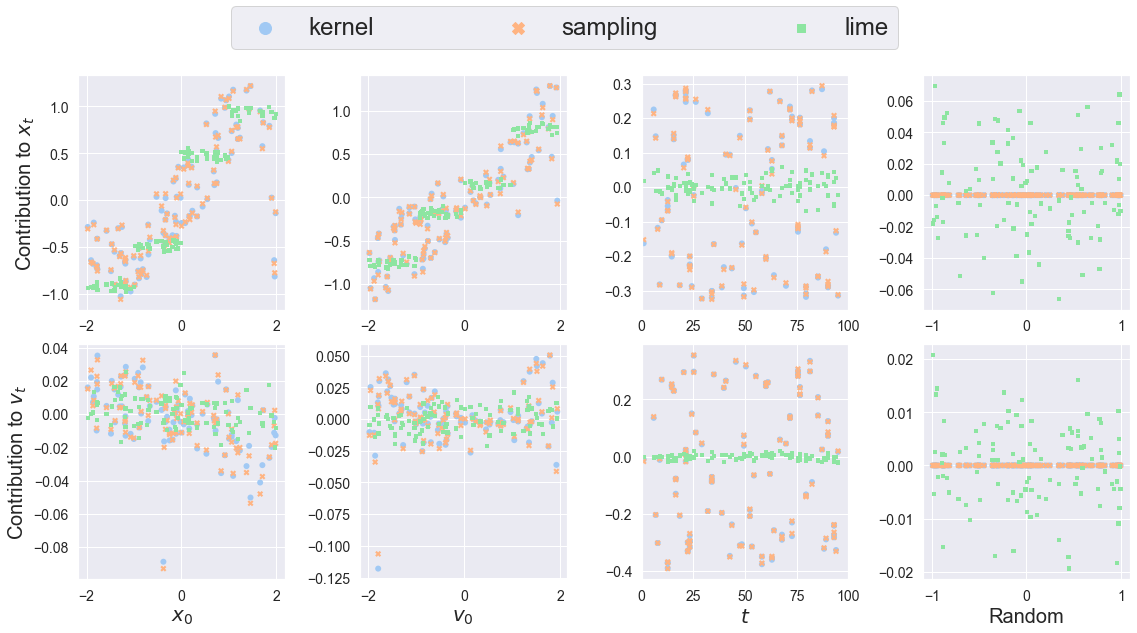

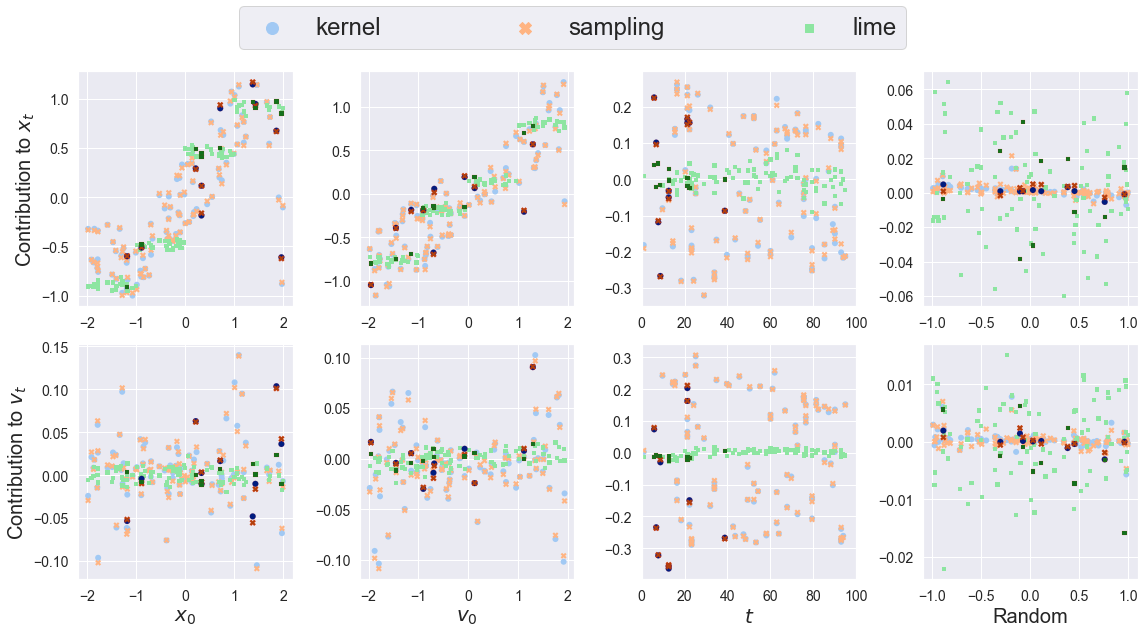

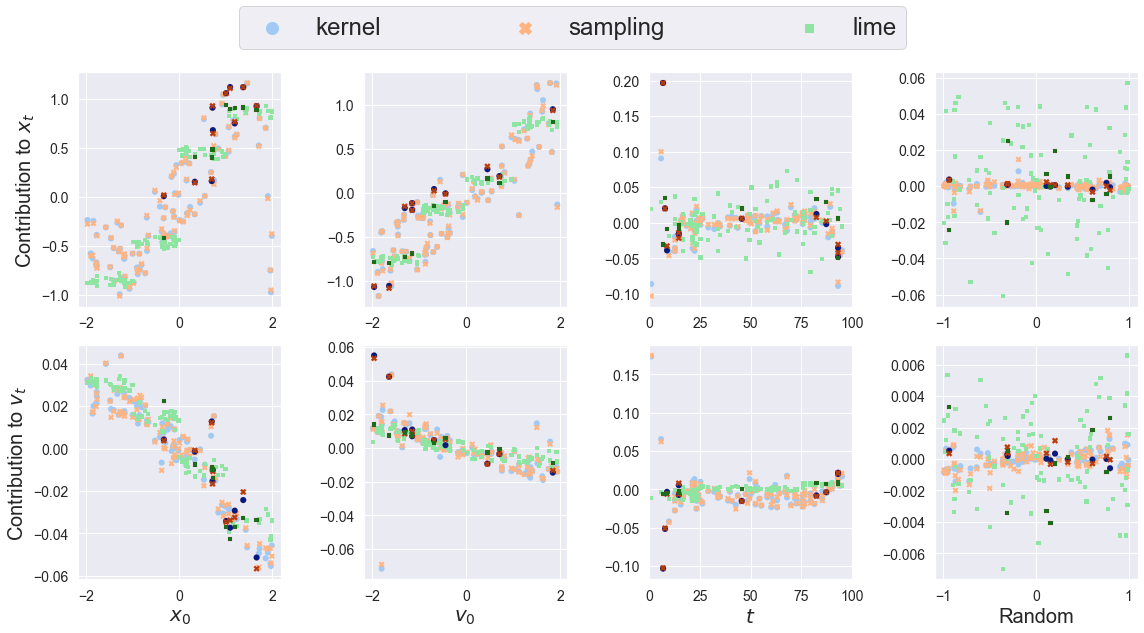

In [9]:
for models_ in big_df['Model'].unique():
    bad_df = find_bad(big_df, model = models_)
    
    plotting_df = big_df.where(big_df["explainer"].isin(["sampling", "kernel", "lime"])).where(big_df["Model"]==models_).dropna()
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            if i==0 and j==0:
                sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none", palette = "pastel", legend = True)
            else:
                sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none", palette = "pastel", legend = False)
            if models_ != "True":
                sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=bad_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="red", palette = "dark", legend = False)
            
            axs[j,i].set_ylabel(None)
            axs[0,i].set_xlabel(None)

            axs[1,i].set_xlabel(plot_features[i], fontsize = 20)
            axs[j,i].tick_params(axis='both', which='major', labelsize=14)

    axs[0,0].get_legend().remove()
    axs[0,2].set(xlim=(0, 100))
    axs[1,2].set(xlim=(0, 100))
    axs[0,0].set_ylabel(r'Contribution to $x_t$', fontsize = 20)
    axs[1,0].set_ylabel(r'Contribution to $v_t$', fontsize = 20)
    
    f.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center",  ncol=3, fontsize = 24, columnspacing=5, markerscale = 2)

    f.tight_layout()
    if save == True:
        f.savefig("Images/Individual/Indiv"+models_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

ValueError: Could not interpret value `gamma` for parameter `x`

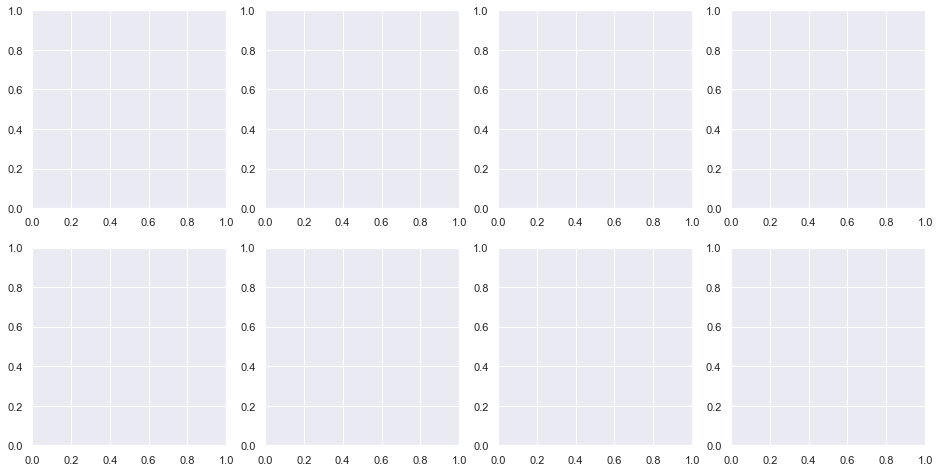

In [10]:
for models_ in big_df['Model'].unique():
    bad_df = find_bad(big_df, model = models_)
    
    plotting_df = big_df.where(big_df["explainer"].isin(["sampling", "kernel", "lime"])).where(big_df["Model"]==models_).dropna()
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            if i==0 and j==0:
                sns.scatterplot(x="gamma", y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none", palette = "pastel", legend = True)
            else:
                sns.scatterplot(x="gamma", y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none", palette = "pastel", legend = False)
            if models_ != "True":
                sns.scatterplot(x="gamma", y=label_+"_"+feat_, data=bad_df, ax=axs[j,i], 
                            linewidth = .1, hue = "explainer", style = "explainer", edgecolor="red", palette = "dark", legend = False)

            axs[0,i].set_title(plot_features[i], fontsize = 20)
            axs[j,i].set_ylabel(None)
            axs[0,i].set_xlabel(None)
            axs[1,i].set_xlabel(r"$\gamma$", fontsize = 20)
            axs[j,i].tick_params(axis='both', which='major', labelsize=14)
    axs[0,0].get_legend().remove()
    axs[0,0].set_ylabel(r'Contribution to $x_t$', fontsize = 20)
    axs[1,0].set_ylabel(r'Contribution to $v_t$', fontsize = 20)
    
    f.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center",  ncol=3, fontsize = 24, columnspacing=5, markerscale = 2)

    f.tight_layout()
    if save == True:
        f.savefig("Images/Individual/x0Indiv"+models_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

In [ ]:
for models_ in big_df['Model'].unique():
    bad_df = find_bad(big_df, model = models_)
    
    plotting_df = big_df.where(big_df["explainer"].isin(["kernel"])).where(big_df["Model"]==models_).dropna()
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            cplot = axs[j,i].tripcolor(plotting_df["x0"], plotting_df["v0"], plotting_df[label_+"_"+feat_])
            f.colorbar(cplot, ax = axs[j,i])
            axs[j,i].set_title("Contribution of "+plot_features[i]+" to "+plot_labels[j], fontsize = 18)
            axs[1,i].set_xlabel(r"$x_0$", fontsize = 20)
            #axs[j,i].legend(loc = 4)
    #f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + model_names[models_], fontsize = 16)
    #f.colorbar(cplot)
    axs[0,0].set_ylabel(r"$v_0$", fontsize = 20)
    axs[1,0].set_ylabel(r'$v_0$', fontsize = 20)
    f.tight_layout()
    f.tight_layout()
    if save == True:
        f.savefig("Images/Individual/Cmap"+models_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

In [ ]:

for models_ in big_df['Model'].unique():
    bad_df = find_bad(big_df, model = models_)
    
    plotting_df = big_df.where(big_df["explainer"].isin(["kernel"])).where(big_df["Model"]==models_).dropna()
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            cplot = axs[j,i].tripcolor(plotting_df["gamma"], plotting_df["x0"], plotting_df[label_+"_"+feat_])
            f.colorbar(cplot, ax = axs[j,i])
            axs[j,i].set_title("Contribution of "+plot_features[i]+" to "+plot_labels[j], fontsize = 18)
            axs[1,i].set_xlabel(r"$\gamma$", fontsize = 20)
            #axs[j,i].legend(loc = 4)
    #f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + model_names[models_], fontsize = 16)
    #f.colorbar(cplot)
    axs[0,0].set_ylabel(r"$x_0$", fontsize = 20)
    axs[1,0].set_ylabel(r'$x_0$', fontsize = 20)
    f.tight_layout()
    f.tight_layout()
    if save == True:
        f.savefig("Images/Individual/Cmapgamma"+models_+"_"+save_suffix+".svg", dpi='figure')


In [ ]:
# Convert Data to Long Form to enable plotting with sns barplot
for model_ in Model_types:
    
    plot_cols = [label_+"_"+feat_ for label_ in duffing.labels for feat_ in duffing.features]
    plot_cols.append("explainer")
    model_df = big_df.where(big_df['Model'] == model_).dropna()
    agg_df = model_df[plot_cols].copy().set_index('explainer')
    temp_df = pd.DataFrame()
    agg_df_2 = pd.DataFrame()
    for j, col in enumerate(agg_df.columns[:8]):
        for expl in agg_df.index.unique():
            temp_df['value'] = agg_df.loc[expl][col].values
            temp_df['feature'] = col
            temp_df['explainer'] = expl
            agg_df_2 = agg_df_2.append(temp_df)

    agg_df_3 = agg_df_2.where(agg_df_2["explainer"].isin(["kernel", "sampling", "lime"])).dropna()
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            agg_df_3 = agg_df_3.replace(label_+"_"+feat_, plot_features[i] +":" +plot_labels[j])
            
    # aggregated feature importance

    # Aggregated

    f, axs = plt.subplots(1, 1, figsize = (8,8), gridspec_kw = dict(width_ratios = [4]))


    sns.barplot(data=agg_df_3, x = 'feature', y = np.abs(agg_df_3['value']), hue = 'explainer', ax = axs, ci = 95, capsize=.2)

    #axs.set_title(r"Aggregate Feature Contributions in the " + model_names[model_], fontsize = 14)
    axs.set_xlabel('Feature : Label', fontsize = 20)
    axs.set_ylabel('Feature Contribution to Label', fontsize = 20)
    axs.legend(fontsize = 20)
    axs.tick_params(axis='both', which='major', labelsize=16)
    f.tight_layout()

    if save == True:
        f.savefig("Images/Aggregate/Agg"+model_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

In [ ]:
num_limits = [(-0.1,0.1), (-0.1,0.1), (-50,50)]

for models_ in big_df['Model'].unique():
    plotting_df = (big_df.where(big_df["explainer"] == "numeric").where(big_df["Model"] == models_).dropna())
    plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                                 columns = features)
    f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                      gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                            linewidth = 1, hue = "explainer", style = "explainer", edgecolor="none", legend = False)
            #axs[j,i].set_title(plot_features[i]+":"+plot_labels[j])
            axs[j,i].set_xlabel(plot_features[i])
            axs[j,i].set_ylabel(None)
            axs[0,i].set_xlabel(None)
            #axs[0,i].xaxis.set_ticklabels([]) 
            axs[1,i].set_xlabel(plot_features[i], fontsize = 20)
            axs[j,i].tick_params(axis='both', which='major', labelsize=14)
            #axs[j,i].tick_params(axis='both', which='minor', labelsize=12)
            #axs[j,i].get_legend().remove()
            #axs[j,i].legend(loc = 4)
            
    axs[0,0].set(ylim=(-10, 10))
    axs[1,0].set(ylim=(-10, 10))        
    axs[0,1].set(ylim=(-10, 10))
    axs[1,1].set(ylim=(-10, 10))
    #axs[0,3].set(ylim=(-10, 10))
    #axs[1,3].set(ylim=(-10, 10))

    
    axs[0,2].set(xlim=(0, 100), ylim=(-120, 120))
    axs[1,2].set(xlim=(0, 100), ylim=(-120, 120))
    axs[0,0].set_ylabel(r'Contribution to $x_t$', fontsize = 20)
    axs[1,0].set_ylabel(r'Contribution to $v_t$', fontsize = 20)
    
        
   # axs.set_xlabel('Feature : Label', fontsize = 20)
   # axs.set_ylabel('Feature Contribution to Label', fontsize = 20)
   # axs.legend(fontsize = 20)
   # axs.tick_params(axis='both', which='major', labelsize=16)
    f.tight_layout()
    
    if save == True:
        f.savefig("Images/Gradient/IndivGrad"+models_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")

In [ ]:

# Convert Data to Long Form to enable plotting with sns barplot
for model_ in Model_types:
    
    plot_cols = [label_+"_"+feat_ for label_ in duffing.labels for feat_ in duffing.features]
    plot_cols.append("explainer")
    model_df = big_df.where(big_df['Model'] == model_).dropna()
    agg_df = model_df[plot_cols].copy().set_index('explainer')
    temp_df = pd.DataFrame()
    agg_df_2 = pd.DataFrame()
    for j, col in enumerate(agg_df.columns[:8]):
        for expl in agg_df.index.unique():
            temp_df['value'] = agg_df.loc[expl][col].values
            temp_df['feature'] = col
            temp_df['explainer'] = expl
            agg_df_2 = agg_df_2.append(temp_df)

    agg_df_3 = agg_df_2.where(agg_df_2["explainer"].isin(["numeric"])).dropna()
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            agg_df_3 = agg_df_3.replace(label_+"_"+feat_, plot_features[i] +":" +plot_labels[j])
            
    # aggregated feature importance

    # Aggregated

    f, axs = plt.subplots(1, 1, figsize = (8,8), gridspec_kw = dict(width_ratios = [4]))


    sns.barplot(data=agg_df_3, x = 'feature', y = np.abs(agg_df_3['value']), hue = 'explainer', ax = axs, ci = 95, capsize=.2)

    #axs.set_title(r"Aggregate Feature Contributions in the " + model_ + " Model", fontsize = 14)
    axs.set_xlabel('Feature', fontsize = 20)
    axs.set_ylabel('Feature Contribution', fontsize = 20)
    axs.get_legend().remove()
    axs.tick_params(axis='both', which='major', labelsize=14)
    f.tight_layout()

    if save == True:
        f.savefig("Images/Gradient/Grad"+models_+"_"+save_suffix+".svg", dpi='figure', bbox_inches='tight', format = "svg")
        


In [ ]:
"""
plot_choice = big_df[duffing.features][:30]
plot_choice_arr = pd.DataFrame()
for time in np.linspace(0, 100, 100, endpoint=False):
    plot_choice["t"] = time
    plot_choice["t"] = duffing.scaler.transform(plot_choice)[:,2]
    plot_choice_arr = plot_choice_arr.append(plot_choice)
    
 # Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt   
  
pred_plot_choice_arr = models["True"].predict(plot_choice_arr)


time = range(100)

def f1(time = 0, num_samples = 1000):
    return pred_plot_choice_arr[time*30:(time+1)*30,0]
    
def f2(rand, time = 0):
    return pred_plot_choice_arr[time*30:(time+1)*30,1]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()


ax.set_title(r"Evolution of Datapoints in Phase Space")
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$v_t$")
"""

In [ ]:
"""

# Convert Data to Long Form to enable plotting with sns barplot
for model_ in Model_types:
    
    plot_cols = [label_+"_"+feat_ for label_ in duffing.labels for feat_ in duffing.features]
    plot_cols.append("explainer")
    model_df = big_df.where(big_df['Model'] == model_).dropna()
    agg_df = model_df[plot_cols].copy().set_index('explainer')
    temp_df = pd.DataFrame()
    agg_df_2 = pd.DataFrame()
    for j, col in enumerate(agg_df.columns[:8]):
        for expl in agg_df.index.unique():
            temp_df['value'] = agg_df.loc[expl][col].values
            temp_df['feature'] = col
            temp_df['explainer'] = expl
            agg_df_2 = agg_df_2.append(temp_df)

    agg_df_3 = agg_df_2.where(agg_df_2["explainer"].isin(["kernel", "sampling", "lime"])).dropna()
    for i, feat_ in enumerate(duffing.features):
        for j, label_ in enumerate(duffing.labels):
            agg_df_3 = agg_df_3.replace(label_+"_"+feat_, plot_features[i] +":" +plot_labels[j])
            
    # aggregated feature importance

    # Aggregated

    f, axs = plt.subplots(1, 2, figsize = (16,8), gridspec_kw = dict(width_ratios = [4,4]))


    sns.barplot(data=agg_df_3, x = 'feature', y = np.abs(agg_df_3['value']), hue = 'explainer', ax = axs[0], ci = 95, capsize=.2)

    axs[0].set_title(r"Aggregate Feature Contributions in the " + model_names[model_], fontsize = 14)
    axs[0].set_xlabel('Feature')
    axs[0].set_ylabel('Feature Contribution')

    sns.boxplot(data=agg_df_3, x = 'feature', y = 'value', ax = axs[1], hue = 'explainer')
    axs[1].set_title(r"All Feature Contributions in the " + model_names[model_] , fontsize = 14)
    axs[1].set_xlabel('Feature')
    axs[1].set_ylabel('Feature Contribution')


    f.tight_layout()

    if save == True:
        f.savefig("Images/Aggregate/Agg"+model_+"_"+save_suffix+".svg", dpi='figure')
        """

In [ ]:
 # Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt  

In [ ]:
plot_choice = big_df[duffing.features][:30]
plot_choice_arr = pd.DataFrame()
for time in np.linspace(0, 100, 100, endpoint=False):
    plot_choice["t"] = time
    plot_choice["t"] = duffing.scaler.transform(plot_choice)[:,2]
    plot_choice_arr = plot_choice_arr.append(plot_choice)
    
 # Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt   
  
pred_plot_choice_arr = models["True"].predict(plot_choice_arr)


time = range(100)

def f1(time = 0, num_samples = 1000):
    return pred_plot_choice_arr[time*30:(time+1)*30,0]
    
def f2(rand, time = 0):
    return pred_plot_choice_arr[time*30:(time+1)*30,1]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()


ax.set_title(r"Evolution of Datapoints in Phase Space")
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$v_t$")

In [ ]:
time = range(100)

def f1(time = 0, num_samples = 1000):
    return pred_plot_choice_arr[time*30:(time+1)*30,0]
    
def f2(rand, time = 0):
    return pred_plot_choice_arr[time*30:(time+1)*30,1]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()

In [ ]:
fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()



# XGBoost

In this section we apply XGBoost to the model

In [ ]:
#define XGBoost Model
def compile_and_fit_XGBoost(modelXGB, Xdata, Ydata, validation_split = 0.2,
                            early_stopping_rounds = 10, verbose = True):
    '''
    validation_split: percentage of training data to use for validation and monitor early stopping
    early_stopping_rounds: Minimum number of trees. After that, stop growing the forest if there is no improvement
    pred = modelXGB.predict(X_test)
    print('rmse = ', np.sqrt(np.mean((y_test-pred)**2)))
    '''
    xtrain, xval, ytrain, yval = train_test_split(Xdata, Ydata, 
                                                  test_size = validation_split, random_state = None)
    evalset = [(xtrain, ytrain), (xval, yval)]
    
    modelXGB.fit(xtrain, ytrain, early_stopping_rounds = early_stopping_rounds, 
                 eval_metric='rmse', eval_set=evalset, verbose = verbose)

In [ ]:
# generate XGBoost dataset

duffing.generate(10000, samples = 100, end_time = end_time)
duffing.scale_features() #scale dataset

In [ ]:
f, axs = plt.subplots(1, 2, figsize = (8,4), gridspec_kw = dict(width_ratios = [4, 4]))

for i, label_ in enumerate(labels):
    # create XGBoost model
    modelXGB = xgb.XGBRegressor(
    n_estimators = 100000,  # Maximum number of trees (like epochs for neural networks)
    max_depth = 100,  # Maximum tree depth #prev 3
    eta = 0.1,  # Learning rate per tree
    subsample = 0.8,  # Sub-sample of the training set to use for each tree. Recommended [0.7, 1.0]
    )
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(duffing.X_df[features], 
                                                        duffing.X_df[label_], test_size=0.2, random_state=42)
    compile_and_fit_XGBoost(modelXGB, X_train, y_train) # train the xgboost regressor
    xgb.plot_importance(modelXGB, ax = axs[i], importance_type='gain', show_values = False) # plot the gain importance
    f.suptitle(r"Aggregate Feature Importance According to XGBoost", fontsize = 16)
    axs[i].set_title(r"Contributions to "+label_list[i])
    axs[i].set_xlabel("F score", fontsize = 20)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel(None)
    

f.suptitle(None)
f.tight_layout()
if save==True:
    f.savefig("Images/goodxgboost_random.svg", dpi='figure')

In [ ]:
"""
plot_choice = big_df[duffing.features][:30]
plot_choice_arr = pd.DataFrame()
for time in np.linspace(0, 100, 100, endpoint=False):
    plot_choice["t"] = time
    plot_choice["t"] = duffing.scaler.transform(plot_choice)[:,2]
    plot_choice_arr = plot_choice_arr.append(plot_choice)
    
 # Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt   
  
pred_plot_choice_arr = models["True"].predict(plot_choice_arr)


time = range(100)

def f1(time = 0, num_samples = 1000):
    return pred_plot_choice_arr[time*30:(time+1)*30,0]
    
def f2(rand, time = 0):
    return pred_plot_choice_arr[time*30:(time+1)*30,1]


fig, ax = plt.subplots()
controls = iplt.plot(f1, f2, 'x', time=time)
plt.show()


ax.set_title(r"Evolution of Datapoints in Phase Space")
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$v_t$")

def numeric_norm(dataframe):
    data_copy = dataframe.copy()
    X = dataframe[duffing.features]
    scaled_df = pd.DataFrame(duffing.scaler.inverse_transform(X), columns = duffing.features)
    y = pd.DataFrame(models["True"].predict(X), columns = duffing.labels)
    for i in duffing.labels:
        y_vals = y[i]
        y_mean = y[i].mean()
        Omega = np.zeros_like(y_vals)
        
        for j in duffing.features:
            Omega += np.array(dataframe[i+"_"+j]) * np.array(scaled_df[j])
            
        for j in duffing.features:
            data_copy[i+"_"+j] = np.array(dataframe[i+"_"+j]) * np.array(y_vals) / Omega
        
    return data_copy
    
def scale_numeric(dataframe):
    data_out = dataframe.copy()
    max_val = np.max(big_df.where(big_df["explainer"] != "numeric").dropna().loc[:,"xt_x0":"vt_t"].max())
    scaler = MinMaxScaler((-max_val, max_val))
    data_out.loc[:,"xt_x0":"vt_t"]=scaler.fit_transform(dataframe.loc[:,"xt_x0":"vt_t"])
    return data_out 
    
background = shap.sample(duffing.X_df[duffing.features], 100)

temp_explainer = shap.KernelExplainer(models["Simple"], background)
temp_vals = temp_explainer.shap_values(pd.DataFrame(duffing.scaler.transform(X[:100])), columns = duffing.features)

plotting_df = duffing.vals_to_df(temp_vals, X[:100])
plotting_df[duffing.features] = pd.DataFrame(duffing.scaler.inverse_transform(big_df[duffing.features]), 
                                             columns = features)
f, axs = plt.subplots(len(duffing.labels), len(duffing.features), figsize = (len(duffing.features)*4,len(duffing.labels)*4), 
                  gridspec_kw = dict(width_ratios = [4 for i in duffing.features]))
for i, feat_ in enumerate(duffing.features):
    for j, label_ in enumerate(duffing.labels):
        sns.scatterplot(x=feat_, y=label_+"_"+feat_, data=plotting_df, ax=axs[j,i], 
                        linewidth = .1, hue = "explainer", style = "explainer", edgecolor="none")
        axs[j,i].set_title(plot_features[i]+":"+plot_labels[j])
        axs[j,i].set_xlabel('Index')
        axs[j,i].set_ylabel('Feature Contribution')
f.suptitle(r"Individual Feature Contributions to $x_t$ and $v_t$ in the " + models_ + " Model", fontsize = 16)

f.tight_layout()
"""